# Experiment Tracking

## Introduction
- ML Experiment: the process of building an ML model
- Experiment run: each trial in an ML experiment
- Run artifact: any file that is associated with an ML run
- Experiment metadata: all info asscociated with the model

Experiment tracking is the process of keeping track of all the relevant info from an ML experiment, which includes:
- Source Code
- Environment
- Data
- Model
- Hyperparameters
- Metric

It is so important because:
- Reproducibility
- Organization
- Optimization


## MLflow
An open source platform for the ML lifecycle. It is basically a python package that contains 4 modules:
- Tracking: this module helps with the organization of experiments into runs, and it keeps track of:
    - parameters: includes hyperparameter, path to the data, etc. it includes anything that affects the metrics of the model
    - metrics: such as accuracy, metrics from the test or validation
    - metadata: via tags such as developer names
    - artifacts: such as visualization, etc
    - models

        MLflow automatically logs extra information about the run such as:
        - Source code
        - Version of the code (git commit)
        - Start and end time
        - Author

- Models
- Model Registry
- Projects




In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error as rmse
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
import mlflow.xgboost
import pickle

In [2]:
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("ride_duration_pred_experiment")

<Experiment: artifact_location='/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/mlruns/1', creation_time=1748566306100, experiment_id='1', last_update_time=1748566306100, lifecycle_stage='active', name='ride_duration_pred_experiment', tags={}>

In [3]:
# create a fuction to load the dataset and train the model

def read_dataframe(filename):
    # read the parquet file
    df = pd.read_parquet(filename)
    
    # duration column creation and conversion to minutes
    df_trip_duration = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df["trip_duration"] = df_trip_duration
    df.trip_duration = df.trip_duration.apply(lambda td: td.total_seconds() / 60)

    # duration between 1 and 60 minutes
    df = df[(df.trip_duration >= 1) & (df.trip_duration <= 60)]

    # categorical and numerical columns selection
    categorical_cols = ["pulocationid", "dolocationid"]
    # numerical_cols = ["trip_distance"]

    # turning categorical columns to string
    df[categorical_cols] = df[categorical_cols].astype(str)

    return df

In [4]:
df_train = read_dataframe("./ride_duration_pred_and_exp_tracking/dataset/cleaned_dataset/yellow_tripdata_2023-01_cleaned.parquet")
df_validation = read_dataframe("ride_duration_pred_and_exp_tracking/dataset/cleaned_dataset/yellow_tripdata_2023-02_cleaned.parquet")

In [5]:
len(df_train), len(df_validation)

(3009173, 2855951)

In [6]:
# model training code
categorical_cols = ["pulocationid", "dolocationid"]
numerical_cols = ["trip_distance"]

dv = DictVectorizer()

# train_dict
train_dicts = df_train[categorical_cols + numerical_cols].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)

val_dicts = df_validation[categorical_cols + numerical_cols].to_dict(orient="records")
X_val = dv.transform(val_dicts)


In [7]:
target = "trip_duration"
y_train = df_train[target].values
y_val = df_validation[target].values

In [ ]:
# using mlflow to track experiments
with mlflow.start_run():
    mlflow.set_tag("developer", "prof")
    mlflow.set_tag("model", "linear_regression")

    mlflow.log_param("train_data_path", "./ride_duration_pred_and_exp_tracking/dataset/cleaned_dataset/yellow_tripdata_2023-01_cleaned.parquet")
    mlflow.log_param("validation_data_path", "./ride_duration_pred_and_exp_tracking/dataset/cleaned_dataset/yellow_tripdata_2023-02_cleaned.parquet")

    mlflow.log_param("length_train_data", len(df_train))
    mlflow.log_param("length_validation_data", len(df_validation))
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # y_pred
    y_pred_lr = lr.predict(X_val)
        
    # mean_squared_error
    lr_rmse = rmse(y_val, y_pred_lr)
    mlflow.log_metric("rmse", lr_rmse)
    mlflow.sklearn.log_model(lr, artifact_path="models/lr")
    mlflow.log_artifact(local_path="./ride_duration_pred_and_exp_tracking/models/linear_regression_model.bin", artifact_path="models/")

    # lr


2025/05/31 01:20:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run exultant-swan-344 at: http://127.0.0.1:5000/#/experiments/1/runs/d9f40bf0f8d04927bcf685734d26d8d4
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


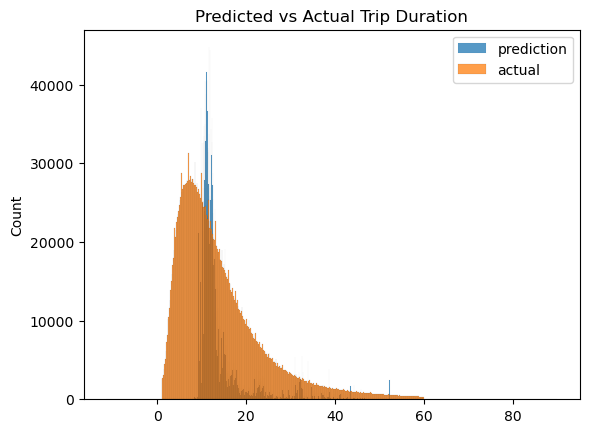

In [12]:
# visualizing the predictions vs actual values
sns.histplot(y_pred_lr, label="prediction")
sns.histplot(y_train, label="actual")
plt.legend()
# plt.xlabel("Trip Duration (minutes)")
# plt.ylabel("Frequency")
plt.title("Predicted vs Actual Trip Duration")
plt.show()

In [13]:

# y_pred_train = lr.predict(X_train)
# rmse(y_train, y_pred_train)

with mlflow.start_run():
    mlflow.set_tags({
        "developer": "prof",
        "model": "ridge_regression"
    })
    mlflow.log_param("train_data_path", "./ride_duration_pred_and_exp_tracking/dataset/cleaned_dataset/yellow_tripdata_2023-01_cleaned.parquet")
    mlflow.log_param("validation_data_path", "./ride_duration_pred_and_exp_tracking/dataset/cleaned_dataset/yellow_tripdata_2023-02_cleaned.parquet")
    mlflow.log_param("length_train_data", len(df_train))
    mlflow.log_param("length_validation_data", len(df_validation))

    lasso_model = Lasso()
    lasso_model.fit(X_train, y_train)

    # y_pred
    y_pred_lasso = lasso_model.predict(X_val)
        
    # mean_squared_error
    lasso_rmse = rmse(y_val, y_pred_lasso)
    mlflow.log_metric("rmse", lasso_rmse)
    mlflow.sklearn.log_model(lasso_model, artifact_path="models/lasso")
    mlflow.log_artifact("./ride_duration_pred_and_exp_tracking/models/lasso_model.bin", artifact_path="models/lasso")


2025/05/31 01:23:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run bedecked-bass-871 at: http://127.0.0.1:5000/#/experiments/1/runs/cb0a345896a248f1a320e7c88d714b6a
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [ ]:
# visualizing the predictions vs actual values
sns.histplot(y_pred_lasso, label="prediction")
sns.histplot(y_train, label="actual")
plt.legend()
# plt.xlabel("Trip Duration (minutes)")
# plt.ylabel("Frequency")
plt.title("Predicted vs Actual Trip Duration")
plt.show()

In [16]:
with mlflow.start_run():
    mlflow.set_tags({
        "developer": "prof",
        "model": "ridge_regressiion"
    })
    mlflow.log_param("train_data_path", "./ride_duration_pred_and_exp_tracking/dataset/cleaned_dataset/yellow_tripdata_2023-01_cleaned.parquet")
    mlflow.log_param("validation_data_path", "./ride_duration_pred_and_exp_tracking/dataset/cleaned_dataset/yellow_tripdata_2023-02_cleaned.parquet")
    mlflow.log_param("length_train_data", len(df_train))
    mlflow.log_param("length_validation_data", len(df_validation))

    ridge = Ridge()
    ridge.fit(X_train, y_train)

    y_pred_ridge = ridge.predict(X_val)

    ridge_rmse = rmse(y_val, y_pred_ridge)
    mlflow.log_metric("rmse", ridge_rmse)
    mlflow.sklearn.log_model(ridge, artifact_path="models/ridge", input_example={"pulocationid": "1", "dolocationid": "2", "trip_distance": 5.0})
    mlflow.log_artifact("./ride_duration_pred_and_exp_tracking/models/ridge_model.bin", artifact_path="models/ridge")

/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
2025/05/31 01:32:15 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: ValueError('X has 3 features, but Ridge is expecting 516 features as input.'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2025/05/31 01:32:22 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": {
    "pulocationid": "1",
    "dolocationid": "2",
    "trip_distance": 5.0
  }
}. Alternatively, you can avoid passing input example and pass model signature instead when logging the model. To ensure the input example is valid prior to serving, please try calling `mlflow.models.validate_serving_input` on the model uri and serving input example. A serving input example

🏃 View run delightful-chimp-372 at: http://127.0.0.1:5000/#/experiments/1/runs/4721afc9252649a69531bc73c3c4f9d7
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/1


In [20]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [21]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

        y_pred_boost = booster.predict(valid)
        xgboost_rmse = rmse(y_val, y_pred_boost)
        mlflow.log_metric("rmse", xgboost_rmse)
    
    return {'loss': xgboost_rmse, 'status': STATUS_OK}

In [22]:
from math import exp

exp(-3), exp(0)

(0.049787068367863944, 1.0)

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # learning rate between 0.049787068367863944 to 1.0
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42,
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|                                                                             | 0/50 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003678 seconds
INFO:hyperopt.tpe:TPE using 0 trials
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:53:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.12910                                                                                              
[1]	validation-rmse:4.65243                                                                                              
[2]	validation-rmse:4.61201                                                                                              
[3]	validation-rmse:4.60594                                                                                              
[4]	validation-rmse:4.60507                                                                                              
[5]	validation-rmse:4.60466                                                                                              
[6]	validation-rmse:4.60625                                                                                              
[7]	validation-rmse:4.60788                                                                                              
[8]	validation-rmse:4.60

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009602 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 4.633070
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [01:56:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99064                                                                                              
[1]	validation-rmse:8.10064                                                                                              
[2]	validation-rmse:7.37630                                                                                              
[3]	validation-rmse:6.78481                                                                                              
[4]	validation-rmse:6.31385                                                                                              
[5]	validation-rmse:5.93963                                                                                              
[6]	validation-rmse:5.64111                                                                                              
[7]	validation-rmse:5.41064                                                                                              
[8]	validation-rmse:5.23

INFO:hyperopt.tpe:build_posterior_wrapper took 0.092222 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:01:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.34945                                                                                              
[1]	validation-rmse:5.93785                                                                                              
[2]	validation-rmse:5.26131                                                                                              
[3]	validation-rmse:4.93541                                                                                              
[4]	validation-rmse:4.78971                                                                                              
[5]	validation-rmse:4.72059                                                                                              
[6]	validation-rmse:4.68334                                                                                              
[7]	validation-rmse:4.66403                                                                                              
[8]	validation-rmse:4.65

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002740 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:03:51] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.81059                                                                                              
[1]	validation-rmse:6.40886                                                                                              
[2]	validation-rmse:5.59781                                                                                              
[3]	validation-rmse:5.13709                                                                                              
[4]	validation-rmse:4.89494                                                                                              
[5]	validation-rmse:4.76721                                                                                              
[6]	validation-rmse:4.69694                                                                                              
[7]	validation-rmse:4.65730                                                                                              
[8]	validation-rmse:4.63

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004276 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:08:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.66502                                                                                              
[1]	validation-rmse:7.57579                                                                                              
[2]	validation-rmse:6.75087                                                                                              
[3]	validation-rmse:6.14004                                                                                              
[4]	validation-rmse:5.68662                                                                                              
[5]	validation-rmse:5.36188                                                                                              
[6]	validation-rmse:5.13316                                                                                              
[7]	validation-rmse:4.97242                                                                                              
[8]	validation-rmse:4.85

INFO:hyperopt.tpe:build_posterior_wrapper took 0.010439 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:14:10] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.51982                                                                                              
[1]	validation-rmse:9.02294                                                                                              
[2]	validation-rmse:8.57270                                                                                              
[3]	validation-rmse:8.16654                                                                                              
[4]	validation-rmse:7.80062                                                                                              
[5]	validation-rmse:7.47061                                                                                              
[6]	validation-rmse:7.17560                                                                                              
[7]	validation-rmse:6.91043                                                                                              
[8]	validation-rmse:6.67

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003208 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:15:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.51308                                                                                              
[1]	validation-rmse:9.00813                                                                                              
[2]	validation-rmse:8.54773                                                                                              
[3]	validation-rmse:8.13116                                                                                              
[4]	validation-rmse:7.75226                                                                                              
[5]	validation-rmse:7.41169                                                                                              
[6]	validation-rmse:7.10214                                                                                              
[7]	validation-rmse:6.82553                                                                                              
[8]	validation-rmse:6.57

INFO:hyperopt.tpe:build_posterior_wrapper took 0.007019 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:20:54] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.47196                                                                                              
[1]	validation-rmse:8.93135                                                                                              
[2]	validation-rmse:8.44219                                                                                              
[3]	validation-rmse:8.00251                                                                                              
[4]	validation-rmse:7.60855                                                                                              
[5]	validation-rmse:7.25302                                                                                              
[6]	validation-rmse:6.93753                                                                                              
[7]	validation-rmse:6.65482                                                                                              
[8]	validation-rmse:6.40

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005132 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:31:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.19488                                                                                              
[1]	validation-rmse:8.44025                                                                                              
[2]	validation-rmse:7.79836                                                                                              
[3]	validation-rmse:7.24690                                                                                              
[4]	validation-rmse:6.78096                                                                                              
[5]	validation-rmse:6.39324                                                                                              
[6]	validation-rmse:6.06584                                                                                              
[7]	validation-rmse:5.79671                                                                                              
[8]	validation-rmse:5.57

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009433 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:38:55] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.71011                                                                                              
[1]	validation-rmse:9.37509                                                                                              
[2]	validation-rmse:9.06138                                                                                              
[3]	validation-rmse:8.76808                                                                                              
[4]	validation-rmse:8.49394                                                                                              
[5]	validation-rmse:8.23802                                                                                              
[6]	validation-rmse:7.99952                                                                                              
[7]	validation-rmse:7.77713                                                                                              
[8]	validation-rmse:7.56

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001839 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:39:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.62693                                                                                              
[1]	validation-rmse:4.79487                                                                                              
[2]	validation-rmse:4.65601                                                                                              
[3]	validation-rmse:4.62820                                                                                              
[4]	validation-rmse:4.61761                                                                                              
[5]	validation-rmse:4.60616                                                                                              
[6]	validation-rmse:4.60312                                                                                              
[7]	validation-rmse:4.60243                                                                                              
[8]	validation-rmse:4.60

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003344 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:41:33] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.50706                                                                                              
[1]	validation-rmse:8.99534                                                                                              
[2]	validation-rmse:8.53167                                                                                              
[3]	validation-rmse:8.10841                                                                                              
[4]	validation-rmse:7.72754                                                                                              
[5]	validation-rmse:7.38088                                                                                              
[6]	validation-rmse:7.07093                                                                                              
[7]	validation-rmse:6.78951                                                                                              
[8]	validation-rmse:6.53

INFO:hyperopt.tpe:build_posterior_wrapper took 0.009323 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:48:31] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.09222                                                                                              
[1]	validation-rmse:4.68588                                                                                              
[2]	validation-rmse:4.63877                                                                                              
[3]	validation-rmse:4.62094                                                                                              
[4]	validation-rmse:4.61816                                                                                              
[5]	validation-rmse:4.60378                                                                                              
[6]	validation-rmse:4.59906                                                                                              
[7]	validation-rmse:4.59260                                                                                              
[8]	validation-rmse:4.58

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006691 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:50:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.28691                                                                                              
[1]	validation-rmse:7.03038                                                                                              
[2]	validation-rmse:6.17899                                                                                              
[3]	validation-rmse:5.60876                                                                                              
[4]	validation-rmse:5.24400                                                                                              
[5]	validation-rmse:5.01176                                                                                              
[6]	validation-rmse:4.86691                                                                                              
[7]	validation-rmse:4.77387                                                                                              
[8]	validation-rmse:4.71

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003554 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:54:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.10140                                                                                              
[1]	validation-rmse:4.87142                                                                                              
[2]	validation-rmse:4.83662                                                                                              
[3]	validation-rmse:4.80781                                                                                              
[4]	validation-rmse:4.78721                                                                                              
[5]	validation-rmse:4.77343                                                                                              
[6]	validation-rmse:4.75242                                                                                              
[7]	validation-rmse:4.74140                                                                                              
[8]	validation-rmse:4.73

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003385 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss 4.547778
/opt/anaconda3/envs/ride_duration_pred_model_MLOPS/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [02:55:46] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1744329023465/work/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.82631                                                                                              
[1]	validation-rmse:7.83088                                                                                              
[2]	validation-rmse:7.05318                                                                                              
[3]	validation-rmse:6.44209                                                                                              
[4]	validation-rmse:5.97842                                                                                              
[5]	validation-rmse:5.62183                                                                                              
[6]	validation-rmse:5.35945                                                                                              
[7]	validation-rmse:5.16102                                                                                              
[8]	validation-rmse:5.01

In [ ]:
params = {
    'learning_rate': 0.7766228283127976,
    'max_depth': 88,
    'min_child_weight': 3.6683528822606446,
    'objective': 'reg:linear',
    'reg_alpha': 0.12607911132258345,
    'reg_lambda': 0.07295255617586878,
    'seed': 42
}

# mflow.xgboost.autolog()

mflow.xgboost.autolog()

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=100,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)

In [ ]:



best_params = {
    'learning_rate': 0.7766228283127976,
    'max_depth': 88,
    'min_child_weight': 3.6683528822606446,
    'objective': 'reg:linear',
    'reg_alpha': 0.12607911132258345,
    'reg_lambda': 0.07295255617586878,
    'seed': 42
}

mlflow.log_params(best_params)

booster = xgb.train(
    params=params,
    dtrain=train,
    num_boost_round=100,
    evals=[(valid, "validation")],
    early_stopping_rounds=50
)

y_pred_xgb = booster.predict(valid)
xgb_rmse = rmse(y_val, y_pred_xgb)
mlflow.log_metric("rmse", xgb_rmse)

mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")